# Systematics on fit model
The toy datasets we generated in the previous exercise can also be used to check for systematics effect in the model definition. 
Let's say we want to evaluate the systematics due to the choice of using an exponential distributions for the combinatorial shape, how do we do that? 
Typically we define an alternative model, for example a polynomial function, and we evaluate the difference of the parameters of interest over toys, when fitting the same toys with the nominal or the alternative model.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import zfit
from zfit.models.basic import Exponential

import mplhep as hep
hep.style.use("LHCb2") # Or ATLAS, LHCb2...

In [10]:
# Build nominal model
def fit_nominal(df, obs):
    # Signal Gaussian
    g_mean = zfit.Parameter("mean", 10, 0, 20)
    g_sigma = zfit.Parameter("sigma", 2, 0, 5)
    yield_signal_g = zfit.Parameter("yield_signal", len(df), 0, len(df))
    model_sig = zfit.pdf.Gauss(obs=obs, mu=g_mean, sigma=g_sigma)
    model_sig_ext = model_sig.create_extended(yield_signal_g)

    # Background (Exponential)
    lambda_ = zfit.Parameter("lambda", -0.1, -5.0, 0.0)
    yield_bkg = zfit.Parameter("yield_bkg", len(df) * 0.2, 0, len(df))

    exp = Exponential(obs=obs, lambda_=lambda_)
    comb_ext=exp.create_extended(yield_bkg)

    model = zfit.pdf.SumPDF([model_sig_ext, comb_ext])
    return model, model_sig, exp

To do: Build an alternative model with Chebyshev polynominal for the combinatorial component

In [ ]:
# Solution
# Build alternative model
def fit_alternative(df, obs):
    # Signal Gaussian
    mean = zfit.Parameter("mean", 10, 0, 20)
    sigma = zfit.Parameter("sigma", 2, 0, 5)
    yield_signal_g = zfit.Parameter("yield_signal", len(df), 0, len(df))
    model_sig =zfit.pdf.Gauss(obs=obs, mu=mean, sigma=sigma)
    model_sig_ext = model_sig.create_extended(yield_signal_g)

    # Background (Polynomial)

    yield_bkg = zfit.Parameter("yield_bkg", len(df) * 0.2, 0, len(df))
    c0 = zfit.Parameter("c0", -0.1)
    c1 = zfit.Parameter("c1", 0.2)
    poly = zfit.pdf.Chebyshev(obs=obs, coeffs=[c0, c1])
    comb_ext = poly.create_extended(yield_bkg)

    model = zfit.pdf.SumPDF([model_sig_ext, comb_ext])
    return model, model_sig, poly


In [4]:
# Convert data
nominal_params = []
alt_params = []
for i in range(2): # ntoys
    df = pd.read_csv(f"toy_{i}.csv")
    masses = df['mass'].values
    mass_range = (0,20)
    obs = zfit.Space("mass", limits=mass_range)
    data = zfit.Data.from_numpy(obs=obs, array=masses)

    # Perform fit to the toy with nominal model
    alt_model, model_sig_nom, exp_nom = fit_nominal(data, obs)
    nll = zfit.loss.ExtendedUnbinnedNLL(alt_model, data)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    result.hesse()
    cov_matrix = result.covariance()
    nominal_params.append(result.params)

    # Perform fit with alternative model
    alt_model, model_sig_alt, exp_alt = fit_alternative(data, obs)
    nll = zfit.loss.ExtendedUnbinnedNLL(alt_model, data)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    result.hesse()
    cov_matrix = result.covariance()
    alt_params.append(result.params)

2025-05-26 13:34:49.906632: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Example of plotting with zfit

In [5]:
def plot_curve(params, ax, title, model_sig, exp, binwidth, color='red'):
    x_plot = np.linspace(mass_range[0], mass_range[1], 1000)
    signal_pdf_eval = model_sig.pdf(x_plot, norm_range=obs)
    sig_yield_val = params[-1]['yield_signal']['value']
    signal_scaled = sig_yield_val * signal_pdf_eval * binwidth

    background_pdf_eval = exp.pdf(x_plot, norm_range=obs)
    bkg_yield_val = params[-1]['yield_bkg']['value']
    bkg_scaled = bkg_yield_val * background_pdf_eval * binwidth
    total_pdf_eval_nom = signal_scaled + bkg_scaled
    ax.plot(x_plot, total_pdf_eval_nom, label=title, color=color, linewidth=3)

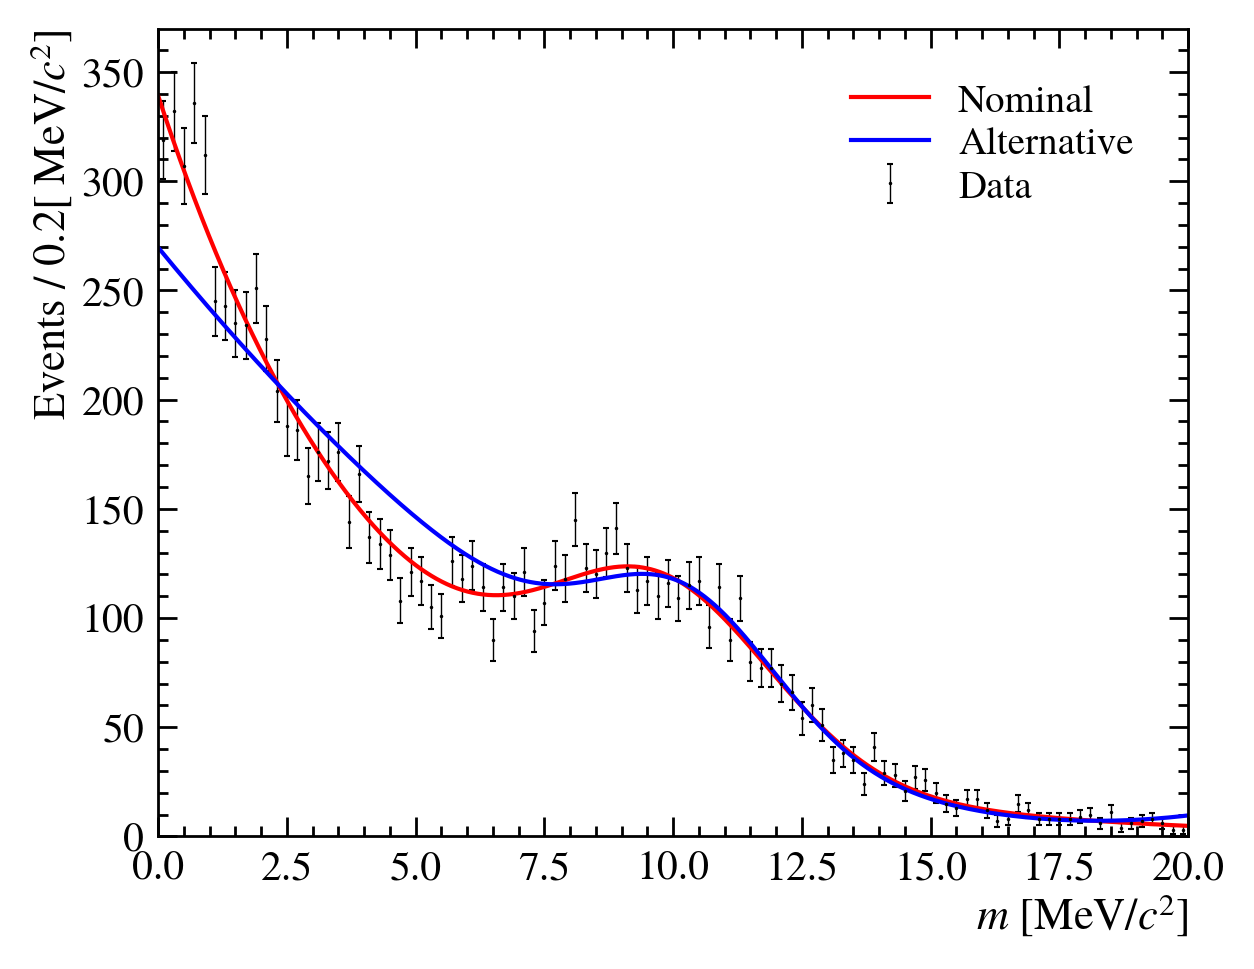

In [6]:
# Plot the results for the latest toy
fig, ax1 = plt.subplots()

bins=100
binwidth = (mass_range[1] - mass_range[0])/bins
# Scatter plot of data points with errors
counts, bin_edges = np.histogram(masses, bins=bins, range=mass_range)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  
errors = np.sqrt(counts)
ax1.errorbar(bin_centers, counts, yerr=errors, fmt='o', color='black', label="Data", markersize=1, elinewidth=1.0)

# Compute nominal fit curve
x_plot = np.linspace(mass_range[0], mass_range[1], 1000)
plot_curve(nominal_params, ax1, 'Nominal', model_sig_nom, exp_nom, binwidth)
plot_curve(alt_params, ax1, 'Alternative', model_sig_alt, exp_alt, binwidth, color='blue')

ylabel = f"Events$~/~${binwidth}" + r"$[~\mathrm{MeV}/c^2]$"
ax1.set_ylabel(ylabel)
ax1.legend()
plt.tight_layout()
ax1.set_xlabel(r"$ m~[\mathrm{MeV}/c^2]$")
ax1.set_xlim(mass_range[0], mass_range[1])
ax1.set_ylim(0, 1.1*np.max(counts))

# Save the results
params = result.params  # Get the fitted parameters

To Do: Plot (nsig_alt - nsig_nom)/nsig_nom, and fit with a gaussian. If the mean is different from zero, or the sigma is too large, you will need to take this as a systematic effect on your measurement

In [7]:
# Solution
syst = []
for i in range(len(nominal_params)):
    nom_val = nominal_params[i]['yield_signal']['value']
    alt_val = alt_params[i]['yield_signal']['value']
    syst.append((nom_val - alt_val)/nom_val)

